# Module 3. Amazon A2I(Augmented AI) integration with Amazon SageMaker Inference

***[Note] 본 핸즈온은 필수가 아니며, 앞의 핸즈온들을 수월하게 마치셨을 경우에만 수행하시는 것을 권장드립니다.***


## Introduction

이 튜토리얼에서는 검증 데이터 및 테스트 데이터에 대해 추론 결과가 좋지 않은 경우들(예: 오분류, 미검출, 낮은 예측 score 등)에 대해 Amazon Augmented AI(이하 A2I)를 사용하는 법을 수행해 보겠습니다. 이를 통해 추론 결과에 대한 보정이나 점진적 훈련(incremental training)을 통해
모델 성능을 개선시킬 수 있습니다.

참고로 A2I는 워크샵을 위해 간소화하였기 때문에, 실제 프로덕션 적용 시에는 엣지 디바이스의 추론 결과를 IoT Core를 통해 AWS로 전송하여 A2I 및 증분 훈련 수행 후 다시 엣지 디바이스로 배포하는 것을 권장드립니다. 아래는 프로덕션 적용 예시입니다.
  
- 어느 정도 학습이 완료된 모델 아티팩트를 s3에 미리 저장 (핸즈온 시간 단축 및 일관성 있는 성능을 위해)
- S3에 저장된 pre-trained 모델을 불러와서 1 epoch만 Incremental training (학습 데이터/검증 데이터 동일)
- 검증 데이터셋에서 추론 후, 오검출/미검출되거나 score가 낮은 샘플들 중 2-5장에 대해 A2I 수행(deploy는 로컬 모드에서 수행하거나 `model.tar.gz`를 로컬로 가져와서 직접 수행)
- Workteam (private team) 생성
- 휴먼 리뷰어의 작업이 완료 후 A2I JSON output 자동 생성
- A2I의 JSON output을 Ground Truth의 Augmented manifest 파일로 변환
- Augmented manifest 파일을 이용해 Incremental training 수행 (학습 데이터 2~5장만 사용)
- Score가 낮은 샘플에 대해 재학습한 모델로 추론 결과 보여주기 (deploy는 로컬 모드에서 수행하거나 model.tar.gz를 로컬로 가져와서 직접 수행)
- Edge 배포용 모델로 컴파일
 

## Amazon A2I란?
Amazon A2I를 사용하면 머신 러닝 추론 결과가 좋지 못한 경우, 사람(휴먼 리뷰어)이 개입하여 추론 결과를 보완하고 선택적으로 보완된 결과를 증분 훈련(incremental training)을 통해 반영하는 머신 러닝 워크플로를 쉽게 구축할 수 있습니다.

Amazon A2I를 휴먼 리뷰 워크플로에 통합하려면 다음 세 가지 리소스들이 필요합니다.

* **Worker task template**: 작업자(worker) UI를 만들기 위한 템플릿입니다. Worker UI를 통해 휴먼 리뷰어에게 지시 사항 및 작업을 완료할 수 있는 interactive 도구들을 제공합니다. 자세한 내용은 https://docs.aws.amazon.com/sagemaker/latest/dg/a2i-instructions-overview.html 을 참조하세요.

* **Human review workflow**: 흐름 정의(flow definition)라고도 하는 휴먼 리뷰 워크플로우입니다. 이 흐름 정의를 사용하여 인력을 구성하고 인력 검토 작업을 수행하는 방법에 대한 정보를 제공합니다. A2I 콘솔 또는 A2I API를 사용하여 흐름 정의를 생성할 수 있습니다. 자세한 내용은 https://docs.aws.amazon.com/sagemaker/latest/dg/a2i-create-flow-definition.html 을 참조하세요.

* **Human loop**: 휴먼 리뷰 워크플로를 시작하는 휴먼 루프입니다. 휴먼 루프가 트리거되면 플로우 정의에 지정된 대로 휴먼 검토 태스크가 휴먼 리뷰어에게(즉, 작업자)에게 전송됩니다.


A2I에 대한 자세한 설명은 아래 웹페이지들을 참조해 주세요.
- https://aws.amazon.com/augmented-ai/ 
- https://docs.aws.amazon.com/sagemaker/latest/dg/a2i-getting-started.html

# 1. Inference Graph 구축

In [1]:
import tensorflow as tf
import os
import numpy as np
from tensorflow.python.platform import gfile
from PIL import Image
from matplotlib.pyplot import imshow

model_filepath = './model_result/inference_graph_frozen.pb'

In [2]:
tf.global_variables_initializer()
tf.reset_default_graph()

추론을 수행하기 위한 그래프를 작성합니다. 물론 추론 컨테이너 환경을 구축하여 SageMaker 엔드포인트에 배포하여 추론을 수행할 수도 있지만, 
실습의 편의성을 위해 별도의 추론 컨테이너 없이 곧바로 네트워크 구조와 모델 파라메터를 로드하여 추론을 수행하겠습니다. 

In [3]:
class MobileNetInference(object):
    
    def __init__(self, model_filepath, class_map):
        self.model_filepath = model_filepath
        self.class_map = class_map
        self.load_graph(model_filepath = model_filepath)
        
        
    def load_graph(self, model_filepath):
        self.graph = tf.Graph()

        # Load the protobuf model file(.pb) and parse it to retrive the graph 
        with tf.gfile.GFile(model_filepath, 'rb') as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())   
        
        # Set default graph as graph
        with self.graph.as_default():
            tf.import_graph_def(graph_def, input_map=None, return_elements=None, name="")   
            self.net_input = self.graph.get_tensor_by_name('input:0')
            self.net_output = self.graph.get_tensor_by_name('MobilenetV1/Predictions/Reshape_1:0')
        
        # Avoid to change graph
        self.graph.finalize()
        
        self.sess = tf.Session(graph = self.graph)
        self.input_node_info = [n for n in graph_def.node if n.op == 'Placeholder']
  

    def get_all_tensors(self):    
        all_tensors = [tensor for op in self.graph.get_operations() for tensor in op.values()]
        return all_tensors
    
    
    def get_input_node_info(self):
        return self.input_node_info[0]
    
    def predict(self, img_filepath, img_size=128, show_image=True):    
        # Open image data and resize it
        img = Image.open(img_filepath)
        img = img.resize((img_size, img_size)) 
        img_arr = np.asarray(img)
        if show_image: 
            imshow(img_arr)
        img_arr = img_arr[np.newaxis, :]

        # Get predictions
        pred_scores = self.sess.run(self.net_output, feed_dict={self.net_input: img_arr} )
        pred_label = np.argmax(pred_scores, axis=1)[0]
        pred_label_str = class_map[pred_label]
        pred_score = pred_scores[0][pred_label]
        
        return pred_label, pred_label_str, pred_score   

모델은 초기화 시에만 생성하여 메모리에 로드합니다. 매번 입력 데이터에 대해 모델을 재생성하는 것은 많은 지연 시간을 초래합니다.

In [4]:
class_map = {0:'background', 1:'dog'}
model = MobileNetInference(model_filepath, class_map)

In [5]:
all_tensors = model.get_all_tensors()
print(all_tensors[-1])

Tensor("MobilenetV1/Predictions/Reshape_1:0", shape=(1, 2), dtype=float32)


In [6]:
model.get_input_node_info()

name: "input"
op: "Placeholder"
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 128
      }
      dim {
        size: 128
      }
      dim {
        size: 3
      }
    }
  }
}

# 2. 샘플 데이터 추론

앞에서 정의한 클래스의 predict 메소드를 사용하여 간단하게 이미지 파일에 대한 추론 결과를 확인할 수 있습니다.

In [7]:
from os import listdir
from os.path import isfile, join

In [8]:
test_dog_img_path = './test_samples/dog'
test_dog_img_list = [f for f in listdir(test_dog_img_path) if isfile(join(test_dog_img_path, f))]

test_bg_img_path = './test_samples/background'
test_bg_img_list = [f for f in listdir(test_bg_img_path) if isfile(join(test_bg_img_path, f))]

In [9]:
test_dog_img_list, test_bg_img_list

(['miniature_pinscher_157.jpg',
  'german_shorthaired_112.jpg',
  'newfoundland_10.jpg',
  'german_shorthaired_98.jpg',
  'beagle_49.jpg',
  'yorkshire_terrier_198.jpg',
  'miniature_pinscher_199.jpg',
  'saint_bernard_23.jpg'],
 ['000000029984.jpg',
  '000000133969.jpg',
  '000000133819.jpg',
  '000000059044.jpg',
  '000000119233.jpg',
  '000000119088.jpg'])

(1, 'dog', 0.9497496)

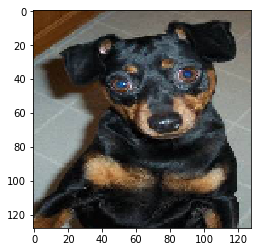

In [10]:
img_filepath = os.path.join(test_dog_img_path, test_dog_img_list[0])
model.predict(img_filepath)

(1, 'dog', 0.9511794)

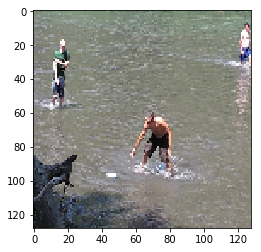

In [11]:
img_filepath = os.path.join(test_bg_img_path, test_bg_img_list[5])
model.predict(img_filepath)

# 3. Creating Human review Workteam or Workforce

인력(workforce)은 데이터셋에 레이블을 지정하기 위해 선택한 작업자 그룹입니다. 벤더가 관리하는 인력인 Amazon Mechanical Turk 인력을 선택하거나, private 인력을 생성할 수 있습니다.

본 섹션에서는 AWS 콘솔로 private 인력을 생성하겠습니다. 아래 순서를 따라 priavte 팀을 생성 후 한 명의 리뷰어를 추가해 봅시다.
역할(role)에 필요한 권한을 추가하려면 https://docs.aws.amazon.com/sagemaker/latest/dg/a2i-permissions-security.html 을 참조해 주세요.

1. AWS Console > Amazon SageMaker > **`Labeling workforces(레이블링 인력)`** 으로 이동 후, 상단의 **`Private(프라이빗)`** 탭을 클릭합니다.
2. 상단의 **`Private`** 탭을 클릭 후, **`Create private team(프라이빗 팀 만들기)`** 버튼을 클릭합니다.
3. Team name 이름에 임의의 이름을 입력하고 **`Create a new Amazon Cognito user group(Amazon Cognito 사용자 그룹 새로 만들기)`** 을 선택한 다음, 하단의 **`Create private team(프라이빗 팀 만들기)`** 버튼을 클릭합니다.
![Fig01](./imgs/fig01.png)
<br>
4. Amazon SageMaker > Labeling workforces 화면 맨 아래의 **`Workers(작업자)`** 탭에셔, 우측 하단의 **`Invite new workers(새 작업자 초대)`** 버튼을 클릭합니다.
![Fig02](./imgs/fig02.png)
<br>
5. 이메일 주소 항목에 여러분의 이메일 주소를 입력하고 **`Invite new workers(새 작업자 초대)`** 버튼을 클릭합니다.
![Fig03](./imgs/fig03.png)
<br>
6. Amazon SageMaker > Labeling workforces 화면으 **`Private teams`** 탭에서 여러분이 아까 생성한 private team 이름의 링크를 클릭합니다.
![Fig04](./imgs/fig04.png)
<br>
7. Workers 탭을 클릭 후, **`Add workers to team(팀에 작업자 추가)`** 버튼을 클릭합니다.
![Fig05](./imgs/fig05.png)
<br>
8. 이메일 주소를 선택 후, **`Add workers to team(팀에 작업자 추가)`** 버튼을 클릭합니다.
![Fig06](./imgs/fig06.png)
<br>
9. Private team 항목에서 private team 이름의 링크를 클릭하면, ARN을 아래 화면과 같이 확인할 수 있습니다. 이 arn을 아래 코드 셀에 붙여 넣으시면 됩니다.
    - `arn:aws:sagemaker:[YOUR REGION]:[YOUR ACCOUNT ID]:workteam/private-crowd/[YOUR PRIVATE TEAM NAME]`
![Fig07](./imgs/fig07.png)   
<br>
10. 참고로, 라벨링 작업이 이루어지는 포털 로그인 URL은 **`Private workforce summary(프라이빗 작업 인력 요약)`** 항목의 **`Labeling portal sign-in URL(레이블 지정 포털 로그인 URL)`** 입니다. 먼저, 여러분이 입력한 이메일을 확인하면 아래 그림과 같은 메일을 받을 수 있고, 이에 따라 포털로 로그인하시면 라벨링 작업을 수행하는 페이지로 접속할 수 있습니다. Human Loop가 활성화되면 여기에 신규 워크로드가 생성됩니다. 
![Fig08](./imgs/fig08.png)   
![Fig09](./imgs/fig09.png)  

상기 과정에서 복사한 `arn:aws:sagemaker:[YOUR REGION]:[YOUR ACCOUNT ID]:workteam/private-crowd/[YOUR PRIVATE TEAM NAME]` 을 아래의 코드 셀에 붙여 넣어 주세요.

In [12]:
#WORKTEAM_ARN = "arn:aws:sagemaker:[YOUR REGION]:[YOUR ACCOUNT ID]:workteam/private-crowd/[YOUR PRIVATE TEAM NAME]"
WORKTEAM_ARN = "arn:aws:sagemaker:us-east-1:143656149352:workteam/private-crowd/daekeun-team-hol"

# 4. A2I Client Setup

In [13]:
import io
import uuid
import boto3
import botocore
import sagemaker
import time
import json

timestamp = time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_session.region_name

# Amazon SageMaker client
sagemaker_client = boto3.client('sagemaker', region)

# Amazon Augment AI (A2I) client
a2i = boto3.client('sagemaker-a2i-runtime')

# Amazon S3 client 
s3 = boto3.client('s3', region)

# Flow definition name - 이 값은 계정 및 지역마다 고유합니다. 여기에서 여러분의 고유 값을 제공할 수도 있습니다.
flowDefinitionName = 'fd-sagemaker-iot-public-workshop-demo-' + timestamp

# Task UI name - 이 값은 계정 및 지역마다 고유합니다. 여기에서 여러분의 고유 값을 제공할 수도 있습니다.
taskUIName = 'ui-sagemaker-iot-public-workshop-demo-' + timestamp

sess = sagemaker.Session()
BUCKET = sess.default_bucket()
OUTPUT_PATH = 's3://{}/a2i-results'.format(BUCKET)
MODEL_PATH = 's3://{}/model'.format(BUCKET)

## 4.1.  Human Task UI 생성

HTML로 구성된 UI 템플릿으로 휴먼 작업 UI 리소스를 생성할 수 있으며, 이 템플릿은 휴먼 루프가 필요할 때마다 휴먼 워커에게 렌더링됩니다.
참고로, 사전에 구축된 70여 가지의 UI를 https://github.com/aws-samples/amazon-a2i-sample-task-uis 에서 확인할 수 있습니다.


In [14]:
template = r"""
<script src="https://assets.crowd.aws/crowd-html-elements.js"></script>

<crowd-form>
  <crowd-image-classifier
    name="annotatedResult"
    src="{{ task.input.taskObject | grant_read_access }}"
    header="Please identify the class in this image"  
    categories="['dog', 'background']"
  >
    <full-instructions header="Classification Instructions">
      <p>Read the task carefully and inspect the image.</p>
      <p>Choose the appropriate label(s) that best suits the image.</p>
    </full-instructions>

    <short-instructions>
      <p>Read the task carefully and inspect the image.</p>
      <p>Choose the appropriate label that best suits the image.</p>
    </short-instructions>
  </crowd-image-classifier>
</crowd-form>
"""

def create_task_ui():
    '''
    Creates a Human Task UI resource.

    Returns:
    struct: HumanTaskUiArn
    '''
    response = sagemaker_client.create_human_task_ui(
        HumanTaskUiName=taskUIName,
        UiTemplate={'Content': template})
    return response

In [15]:
# Create task UI
humanTaskUiResponse = create_task_ui()
humanTaskUiArn = humanTaskUiResponse['HumanTaskUiArn']

## 4.2. Human Review Workflow 생성

이 섹션에서는 플로우 정의를 작성합니다. 플로우 정의를 통해 다음을 지정할 수 있습니다.

- 작업을 수행할 인력
- Worker task template; 인력이 받을 지침
- 작업을 받는 작업자 수 및 작업을 완료하기 위한 시간 제한을 포함한 worker task 구성
- 출력 데이터가 저장될 위치

In [16]:
from sagemaker import get_execution_role
role = get_execution_role()

create_workflow_definition_response = sagemaker_client.create_flow_definition(
        FlowDefinitionName= flowDefinitionName,
        RoleArn= role,
        HumanLoopConfig= {
            "WorkteamArn": WORKTEAM_ARN,
            "HumanTaskUiArn": humanTaskUiArn,
            "TaskCount": 1,
            "TaskDescription": "Identifythe class in an image.",
            "TaskTitle": "Image Classification a2i demo"
        },
        OutputConfig={
            "S3OutputPath" : OUTPUT_PATH
        }
    )
flowDefinitionArn = create_workflow_definition_response['FlowDefinitionArn'] # let's save this ARN for future use

In [17]:
# Describe flow definition - status가 activer가 되어야 합니다.
for x in range(60):
    describeFlowDefinitionResponse = sagemaker_client.describe_flow_definition(FlowDefinitionName=flowDefinitionName)
    print(describeFlowDefinitionResponse['FlowDefinitionStatus'])
    if (describeFlowDefinitionResponse['FlowDefinitionStatus'] == 'Active'):
        print("Flow Definition is active")
        break
    time.sleep(2)

Initializing
Active
Flow Definition is active


## 4.3. Human Loop 시작

휴먼 리뷰 워크플로를 설정했으므로 휴먼 루프를 시작할 준비가 되었습니다. 여기에서 예측 결과가 좋지 않는 경우에만 Human Loop를 시작합니다.
샘플 데이터들은 강아지가 아닌 이미지들을 대상으로 실험해 보겠습니다.

먼저, A2I UI가 표시할 샘플 이미지를 s3 버킷으로 가져옵니다.

In [18]:
!aws s3 sync ./test_samples/background/ s3://{BUCKET}/a2i-results/sample-a2i-images/
    
human_loops_started = []
SCORE_THRESHOLD = .95

In [19]:
for fname in test_bg_img_list:
    img_filepath = os.path.join(test_bg_img_path, fname)
    pred_cls, pred_cls_str, pred_score = model.predict(img_filepath, show_image=False)

    
    # Our condition for triggering a human review    
    if (pred_score < SCORE_THRESHOLD):

        s3_fname='s3://%s/a2i-results/sample-a2i-images/%s' % (BUCKET, fname)
        print(s3_fname)
        humanLoopName = str(uuid.uuid4())        
        inputContent = {
            #"initialValue": str(pred_score[pred_cls]),
            "initialValue": pred_cls_str,
            "taskObject": s3_fname # the s3 object will be passed to the worker task UI to render
        }
        # start an a2i human review loop with an input
        start_loop_response = a2i.start_human_loop(
            HumanLoopName=humanLoopName,
            FlowDefinitionArn=flowDefinitionArn,
            HumanLoopInput={
                "InputContent": json.dumps(inputContent)
            }
        )
        human_loops_started.append(humanLoopName)
        print('Confidence Score of {} is less than the threshold of {}'.format(pred_score, SCORE_THRESHOLD))
        print('Starting human loop with name: {} \n'.format(humanLoopName))
    else:
        print('Confidence Score of {} is above than the threshold of {}'.format(pred_score, SCORE_THRESHOLD))
        print('No human loop created. \n')

Confidence Score of 0.954659819603 is above than the threshold of 0.95
No human loop created. 

Confidence Score of 0.952144384384 is above than the threshold of 0.95
No human loop created. 

Confidence Score of 0.954976141453 is above than the threshold of 0.95
No human loop created. 

s3://sagemaker-us-east-1-143656149352/a2i-results/sample-a2i-images/000000059044.jpg
Confidence Score of 0.941992938519 is less than the threshold of 0.95
Starting human loop with name: 21c33920-7913-4963-870f-43cc55667be3 

s3://sagemaker-us-east-1-143656149352/a2i-results/sample-a2i-images/000000119233.jpg
Confidence Score of 0.939756512642 is less than the threshold of 0.95
Starting human loop with name: f5f74c6a-eb91-430e-8ba2-d6f2fc84abac 

Confidence Score of 0.951179385185 is above than the threshold of 0.95
No human loop created. 



## 4.4. Human Loop Status 확인

In [20]:
completed_human_loops = []
for human_loop_name in human_loops_started:
    resp = a2i.describe_human_loop(HumanLoopName=human_loop_name)
    print('HumanLoop Name: {}'.format(human_loop_name))
    print('HumanLoop Status: {}'.format(resp["HumanLoopStatus"]))
    print('HumanLoop Output Destination: {}'.format(resp["HumanLoopOutput"]))
    print('\n')
    
    if resp["HumanLoopStatus"] == "Completed":
        completed_human_loops.append(resp)

HumanLoop Name: 21c33920-7913-4963-870f-43cc55667be3
HumanLoop Status: InProgress
HumanLoop Output Destination: {u'OutputS3Uri': u's3://sagemaker-us-east-1-143656149352/a2i-results/fd-sagemaker-iot-public-workshop-demo-2020-06-15-08-17-39/2020/06/15/08/17/51/21c33920-7913-4963-870f-43cc55667be3/output.json'}


HumanLoop Name: f5f74c6a-eb91-430e-8ba2-d6f2fc84abac
HumanLoop Status: InProgress
HumanLoop Output Destination: {u'OutputS3Uri': u's3://sagemaker-us-east-1-143656149352/a2i-results/fd-sagemaker-iot-public-workshop-demo-2020-06-15-08-17-39/2020/06/15/08/17/51/f5f74c6a-eb91-430e-8ba2-d6f2fc84abac/output.json'}




In [21]:
workteamName = WORKTEAM_ARN[WORKTEAM_ARN.rfind('/') + 1:]
print("Navigate to the private worker portal and do the tasks. Make sure you've invited yourself to your workteam!")
print('https://' + sagemaker_client.describe_workteam(WorkteamName=workteamName)['Workteam']['SubDomain'])

Navigate to the private worker portal and do the tasks. Make sure you've invited yourself to your workteam!
https://clsherp14m.labeling.us-east-1.sagemaker.aws


In [22]:
completed_human_loops = []
for human_loop_name in human_loops_started:
    resp = a2i.describe_human_loop(HumanLoopName=human_loop_name)
    print('HumanLoop Name: {}'.format(human_loop_name))
    print('HumanLoop Status: {}'.format(resp["HumanLoopStatus"]))
    print('HumanLoop Output Destination: {}'.format(resp["HumanLoopOutput"]))
    print('\n')
    
    if resp["HumanLoopStatus"] == "Completed":
        completed_human_loops.append(resp)

HumanLoop Name: 21c33920-7913-4963-870f-43cc55667be3
HumanLoop Status: Completed
HumanLoop Output Destination: {u'OutputS3Uri': u's3://sagemaker-us-east-1-143656149352/a2i-results/fd-sagemaker-iot-public-workshop-demo-2020-06-15-08-17-39/2020/06/15/08/17/51/21c33920-7913-4963-870f-43cc55667be3/output.json'}


HumanLoop Name: f5f74c6a-eb91-430e-8ba2-d6f2fc84abac
HumanLoop Status: Completed
HumanLoop Output Destination: {u'OutputS3Uri': u's3://sagemaker-us-east-1-143656149352/a2i-results/fd-sagemaker-iot-public-workshop-demo-2020-06-15-08-17-39/2020/06/15/08/17/51/f5f74c6a-eb91-430e-8ba2-d6f2fc84abac/output.json'}




## 4.5. View Task Results  

In [23]:
completed_human_loops[0]

{u'CreationTime': datetime.datetime(2020, 6, 15, 8, 17, 51, 99000, tzinfo=tzlocal()),
 u'FlowDefinitionArn': u'arn:aws:sagemaker:us-east-1:143656149352:flow-definition/fd-sagemaker-iot-public-workshop-demo-2020-06-15-08-17-39',
 u'HumanLoopArn': u'arn:aws:sagemaker:us-east-1:143656149352:human-loop/21c33920-7913-4963-870f-43cc55667be3',
 u'HumanLoopName': u'21c33920-7913-4963-870f-43cc55667be3',
 u'HumanLoopOutput': {u'OutputS3Uri': u's3://sagemaker-us-east-1-143656149352/a2i-results/fd-sagemaker-iot-public-workshop-demo-2020-06-15-08-17-39/2020/06/15/08/17/51/21c33920-7913-4963-870f-43cc55667be3/output.json'},
 u'HumanLoopStatus': u'Completed',
 'ResponseMetadata': {'HTTPHeaders': {'access-control-allow-origin': '*',
   'connection': 'keep-alive',
   'content-length': '831',
   'content-type': 'application/json; charset=UTF-8',
   'date': 'Mon, 15 Jun 2020 08:20:05 GMT',
   'x-amz-apigw-id': 'OKRQWFLrIAMFx6A=',
   'x-amzn-requestid': 'db81b13b-5d14-4b4b-adb5-2da8d0e83653',
   'x-amzn-

In [24]:
import re
import pprint

pp = pprint.PrettyPrinter(indent=2)

for resp in completed_human_loops:
    splitted_string = re.split('s3://' +  BUCKET + '/', resp['HumanLoopOutput']['OutputS3Uri'])
    output_bucket_key = splitted_string[1]

    # load json
    response = s3.get_object(Bucket=BUCKET, Key=output_bucket_key)
    content = response["Body"].read()
    json_output = json.loads(content)
    pp.pprint(json_output)
    print('\n')

{ u'flowDefinitionArn': u'arn:aws:sagemaker:us-east-1:143656149352:flow-definition/fd-sagemaker-iot-public-workshop-demo-2020-06-15-08-17-39',
  u'humanAnswers': [ { u'answerContent': { u'annotatedResult': { u'label': u'background'}},
                       u'submissionTime': u'2020-06-15T08:19:34.099Z',
                       u'workerId': u'9ac6f985c1ba6a93',
                       u'workerMetadata': { u'identityData': { u'identityProviderType': u'Cognito',
                                                               u'issuer': u'https://cognito-idp.us-east-1.amazonaws.com/us-east-1_WS9xgRnZ2',
                                                               u'sub': u'69386bae-a84e-414a-88d1-35a2031479d9'}}}],
  u'humanLoopName': u'21c33920-7913-4963-870f-43cc55667be3',
  u'inputContent': { u'initialValue': u'dog',
                     u'taskObject': u's3://sagemaker-us-east-1-143656149352/a2i-results/sample-a2i-images/000000059044.jpg'}}


{ u'flowDefinitionArn': u'arn:aws:sagemaker:

# 5. Incremental Training

TODO